In [1]:
import fastai
import math
import os
import pprint
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

from datetime import (
    datetime
)

from sklearn.preprocessing import (
    StandardScaler
)

from fastai.tabular.all import (
    LinBnDrop
)

from fastai.layers import (
    Identity

)

from typing import (
    Callable,
    Dict,
    List,
    Tuple
)

from Quick.cleaning.loading import (
    examine_dataset,
    remove_infs_and_nans
)

from Quick.cleaning.utils import (
    get_file_path
)

from Quick.runners.deep import (
    run_deep_nn_experiment
)

from Quick.runners.residual import (
    run_residual_deep_nn_experiment
)

from Quick.runners.sk import (
    run_sk_experiment
)

from Quick.runners.torch import (
    run_torch_nn_experiment
)

from rff.layers import (
    GaussianEncoding,
)

from Quick.constants import *

pretty = pprint.PrettyPrinter(indent=4).pprint

from fastai.metrics import (
    BalancedAccuracy,
    F1Score,
    MatthewsCorrCoef,
    Precision,
    Recall,
    RocAuc
)

METRICS: list = [
    accuracy, 
    BalancedAccuracy(), 
    # RocAuc(), 
    MatthewsCorrCoef(), 
    F1Score(average='macro'), 
    Precision(average='macro'), 
    Recall(average='macro')
]

In [2]:
use_gpu: bool = False

if(use_gpu):

    if(torch.backends.mps.is_available()): # For Mac M1/M2 chips
        device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    else: # For NVIDIA cuda chips
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

else:
    device = torch.device('cpu')

print(f'We are currently using the device: {device}')

We are currently using the device: cpu


In [3]:
data_path_1: str = r'C:\python\TrafficFlowForecasting\warins_experiments\data\darknet'
data_sets_1: list = [
    'Darknet_cleaned.csv'
]

file_path_1: callable = get_file_path(data_path_1)
file_set_1: list = list(map(file_path_1, data_sets_1))

print(f'The datasets we will be working with are:')
pretty(file_set_1)

The datasets we will be working with are:
[   'C:\\python\\TrafficFlowForecasting\\warins_experiments\\data\\darknet\\Darknet_cleaned.csv']


In [4]:
dataset_1 = examine_dataset(0, file_set_1, data_sets_1)

Dataset 0/1: We now look at C:\python\TrafficFlowForecasting\warins_experiments\data\darknet\Darknet_cleaned.csv


Loading Dataset: C:\python\TrafficFlowForecasting\warins_experiments\data\darknet\Darknet_cleaned.csv
	To Dataset Cache: ./cache/Darknet_cleaned.csv.pickle


        File:				C:\python\TrafficFlowForecasting\warins_experiments\data\darknet\Darknet_cleaned.csv  
        Job Number:			0
        Shape:				(141481, 85)
        Samples:			141481 
        Features:			85
    


In [5]:
# we are going to select a random subset of our data

df = dataset_1['Dataset'].sample(frac=0.1, random_state=42) 

In [6]:
dataset_1['Dataset'].shape

(141481, 85)

In [7]:
df.shape

(14148, 85)

In [8]:
df.columns

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Len

In [9]:
#renaming the application type and traffic type
df.rename(columns={'Label': 'Traffic Type', 'Label1': 'Application Type'}, inplace=True)
df.columns

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Len

In [ ]:
df.to_csv(r"C:\python\TrafficFlowForecasting\warins_experiments\data\darknet\Darknet_cleaned.csv")

In [10]:
flow_iat_columns = [
    'Flow IAT Mean', 
    'Flow IAT Std', 
    'Flow IAT Max',
    'Flow IAT Min',
]

flow_columns = [
    'Flow Duration', 
    'Flow Bytes/s',
    'Flow Packets/s', 
]

fwd_packets_columns = [
    'Fwd Packet Length Max', 
    'Fwd Packet Length Min',
    'Fwd Packet Length Mean', 
    'Fwd Packet Length Std',

    'Total Fwd Packet', 
    'Total Length of Fwd Packet', 
    'Fwd Packets/s',
]

bwd_packets_columns = [
    'Bwd Packet Length Max', 
    'Bwd Packet Length Min',
    'Bwd Packet Length Mean', 
    'Bwd Packet Length Std', 

    'Total Bwd packets',
    'Total Length of Bwd Packet',
    'Bwd Packets/s', 
]

fwd_iat_columns = [
    'Fwd IAT Total', 
    'Fwd IAT Mean', 
    'Fwd IAT Std',
    'Fwd IAT Max', 
    'Fwd IAT Min', 
]

bwd_iat_columns = [
    'Bwd IAT Total', 
    'Bwd IAT Mean',
    'Bwd IAT Std', 
    'Bwd IAT Max', 
    'Bwd IAT Min', 
]

packet_columns = [
    'Packet Length Min', 
    'Packet Length Max',
    'Packet Length Mean', 
    'Packet Length Std', 
    'Packet Length Variance',

    'Average Packet Size',
]

flag_columns = [
    'FIN Flag Count', 
    'SYN Flag Count', 
    'RST Flag Count', 
    'PSH Flag Count',
    'ACK Flag Count',

    'Fwd PSH Flags',
]

header_columns = [
    'Fwd Header Length', 
    'Bwd Header Length', 
]

idle_columns = [
    'Idle Mean', 
    'Idle Std',
    'Idle Max', 
    'Idle Min', 
]

segment_size_columns = [
    'Fwd Segment Size Avg', 
    'Fwd Seg Size Min', 

    'Bwd Segment Size Avg', 
]

subflow_columns = [
    'Subflow Fwd Packets', 
    'Subflow Fwd Bytes',
    'Subflow Bwd Bytes', 
]

label_columns = [
    'Traffic Type', 
    'Application Type'
]

other_columns = [
    'Protocol', 
    'Down/Up Ratio', 
    'Bwd Packet/Bulk Avg',
    'Bwd Bulk Rate Avg', 

    'FWD Init Win Bytes', 
    'Bwd Init Win Bytes',

    'Fwd Act Data Pkts', 
]

feature_groups = {
    'flow_iat': flow_iat_columns,
    'flow': flow_columns,
    'fwd_packets': fwd_packets_columns,
    'bwd_packets': bwd_packets_columns,
    'fwd_iat': fwd_iat_columns,
    'bwd_iat': bwd_iat_columns,
    'packet': packet_columns,
    'flag': flag_columns,
    'header': header_columns,
    'idle': idle_columns,
    'segment_size': segment_size_columns,
    'subflow': subflow_columns,
    'other': other_columns,
}

features = []

for group in feature_groups.values():
    features.extend(group)

columns = features + label_columns

# we reorder the columns
df = df[columns]


In [ ]:
df.head()

Shape of Input Data: (14148, 63)


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.158528,1.150673,0.650760,0.432176,0.878386,0.562133,0.410038,0.485173,0.432176,00:02
1,1.036123,1.104000,0.620007,0.441410,0.878297,0.530605,0.421121,0.460985,0.441410,00:02
2,0.928783,0.945124,0.669495,0.464782,0.903964,0.590473,0.446489,0.623869,0.464782,00:02
3,0.907102,0.967380,0.643337,0.470499,0.903947,0.560713,0.447591,0.551649,0.470499,00:02
4,0.871444,0.929096,0.680099,0.467500,0.906635,0.604099,0.443772,0.545577,0.467500,00:02
5,0.837824,0.865113,0.689643,0.518898,0.921148,0.616075,0.512418,0.560217,0.518898,00:02
6,0.775700,0.888815,0.691057,0.519151,0.919433,0.620655,0.523720,0.591626,0.519151,00:02
7,0.728067,0.924417,0.647579,0.501347,0.919753,0.575173,0.502434,0.634187,0.501347,00:02
8,0.698541,0.908265,0.646518,0.498489,0.924027,0.573819,0.488420,0.565849,0.498489,00:02
9,0.693183,0.991719,0.620361,0.483399,0.904317,0.540142,0.486542,0.615460,0.483399,00:02


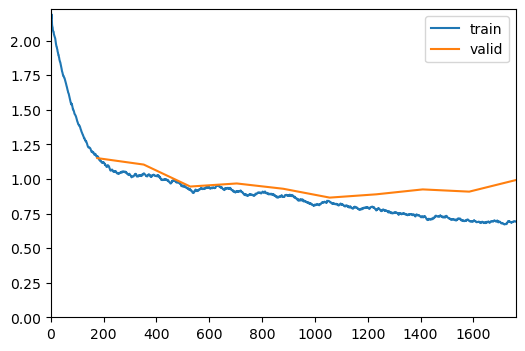

c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.9917188882827759, accuracy:  62.04%


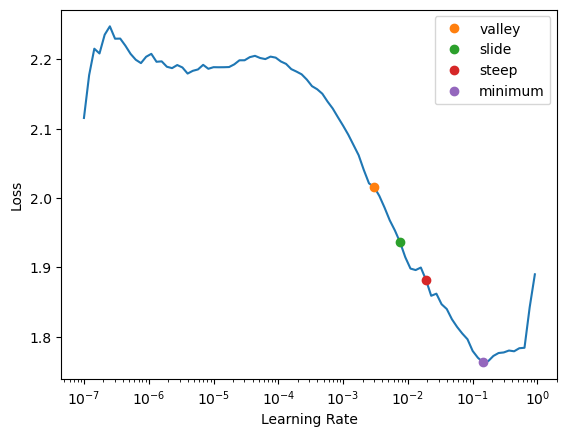

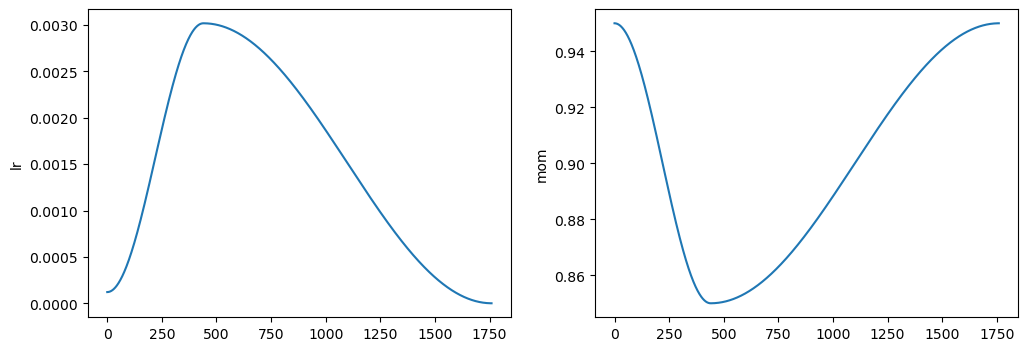

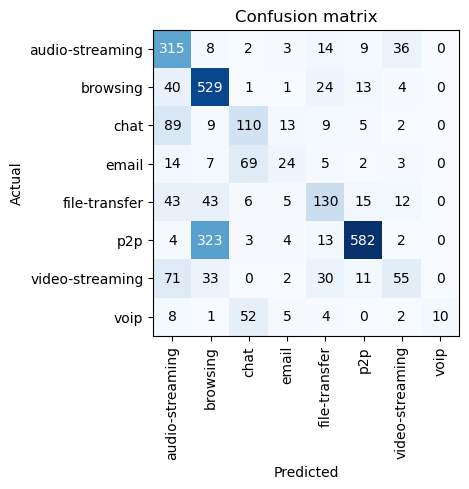

In [11]:
results_dnn = run_deep_nn_experiment(
    df.drop(['Traffic Type'], axis=1), # we perform classification on the application type, so we drop traffic type
    dataset_1['File'],                 # stuff for logging
    'Application Type',                # the column we are trying to predict
    (100 for _ in range(10))           # we use 10 layers with 100 neurons each
)

Shape of Input Data: (14148, 63)
Layer sizes: [64, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 8], length: 12
Number of residual blocks: 9
Residual locations:  [1, 2, 3, 4, 5, 6, 7, 8, 9]


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.613121,1.499080,0.552492,0.378084,0.785460,0.439629,0.363250,0.371435,0.378084,00:02
1,1.060294,1.160463,0.646872,0.469121,0.870551,0.555680,0.465048,0.501678,0.469121,00:02
2,0.945461,1.025470,0.673736,0.491800,0.893875,0.588499,0.490146,0.516517,0.491800,00:02
3,0.867411,0.996900,0.663485,0.499405,0.900396,0.578965,0.499226,0.543058,0.499405,00:02
4,0.822149,0.955276,0.694945,0.512487,0.911479,0.616585,0.517475,0.592330,0.512487,00:02
5,0.798508,0.901917,0.684694,0.493184,0.913109,0.603222,0.493301,0.562058,0.493184,00:02
6,0.769755,0.965777,0.667727,0.478005,0.904202,0.582441,0.478513,0.525123,0.478005,00:02
7,0.724006,0.887304,0.702722,0.516955,0.917821,0.626912,0.517248,0.576483,0.516955,00:02
8,0.721835,0.902179,0.699894,0.510282,0.915719,0.623218,0.505910,0.555688,0.510282,00:02
9,0.693188,0.889705,0.693885,0.508130,0.919516,0.615095,0.505209,0.558834,0.508130,00:02


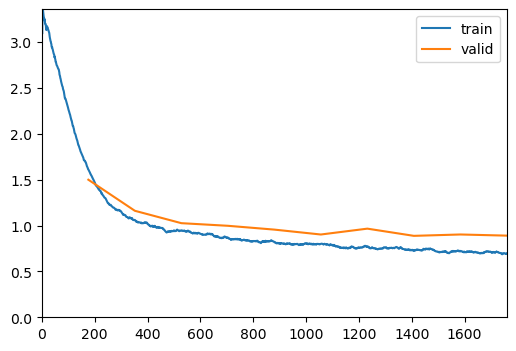

loss: 0.8897051215171814, accuracy:  69.39%


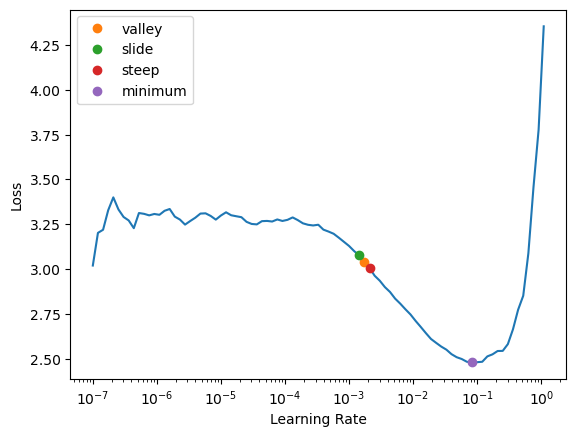

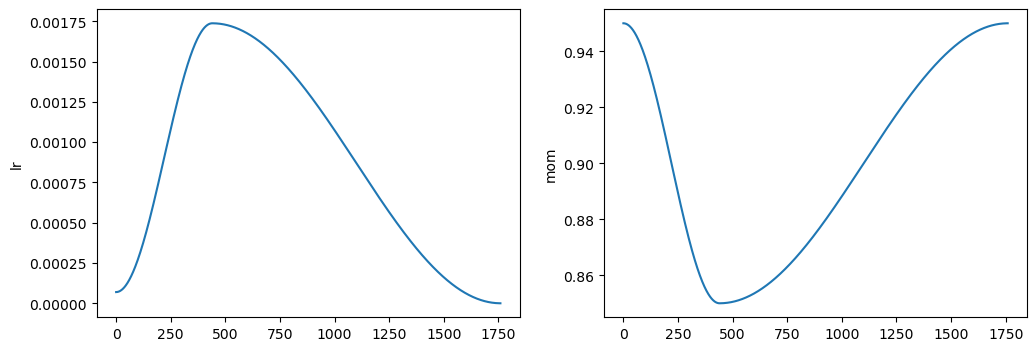

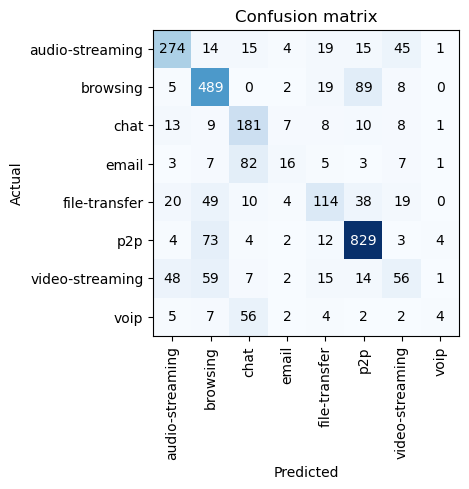

In [12]:
results_res_type_1 = run_residual_deep_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    (100 for _ in range(10))
)

In [13]:
results_sk = run_sk_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type'
)

Shape of Input Data: (14148, 63)
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       387
           1       0.74      0.89      0.81       612
           2       0.61      0.65      0.63       237
           3       0.50      0.43      0.46       124
           4       0.74      0.56      0.64       254
           5       0.91      0.92      0.92       931
           6       0.49      0.36      0.42       202
           7       0.47      0.37      0.41        82

    accuracy                           0.76      2829
   macro avg       0.65      0.62      0.63      2829
weighted avg       0.75      0.76      0.75      2829

	Accuracy: 0.7589254153411099



In [14]:
class BottleneckResidualBlock(nn.ModuleList):
# class BottleneckResidualBlock(Module):
    '''
        A residule block that creates a skip connection around a set of n branches
            where the number of branches is determined by the number of input modules
            in the branches list parameter.

            the residual connection is put through a linear batchnormed layer if the
            input size is different from the output size
            Then, the output of the branches is summed together along with the possibly transformed input
    '''
    def __init__(self, branches: list, layer: int, in_size: int, out_size: int):
        super().__init__(branches)
        
        self.branches = branches
        self.layer = layer

        self.in_size = in_size
        self.out_size = out_size

        if(in_size != out_size):
            self.identity_path = LinBnDrop(in_size, out_size)
        else:
            self.identity_path = Identity()


    def forward(self, inputs):

        fx = self.branches[0](inputs)
        for i in range(len(self.branches) - 1):
            fx += self.branches[i + 1](inputs)

        if(inputs.shape != fx.shape):
            inputs = self.identity_path(inputs)
        return fx + inputs



class Simple_Resnet_Model(nn.Module):
    def __init__(self, input_features=62, layers=[100 for _ in range(10)], output_features=8, config: dict = None, device: str = 'cpu'):
        super().__init__()
        self._layers = []
        _activations = [nn.ReLU(inplace=True) for _ in range(len(layers) - 1)] + [None]

        for i, x in enumerate(layers):
            print(i)
            if (i == 0):
                self._layers.append(BottleneckResidualBlock([LinBnDrop(input_features, layers[i+1], act=_activations[i], lin_first=True)], i, input_features, layers[i+1]))
            elif (i == len(layers) - 1):
                self._layers.append(BottleneckResidualBlock([LinBnDrop(x, output_features, act=_activations[i], lin_first=True)], i, x, output_features))
                # self._layers.append(LinBnDrop(x, output_features, act=_activations[i], lin_first=True))
            else:
                self._layers.append(BottleneckResidualBlock([LinBnDrop(x, layers[i+1], act=_activations[i], lin_first=True)], i, x, layers[i+1]))
        
        self.out = nn.Sequential(*self._layers)     
        
    def forward(self, x):
        return self.out(x)



Shape of Input Data: (14148, 63)
0
1
2
3
4
5
6
7
8
9


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.118461,1.124326,0.666667,0.477737,0.895989,0.582036,0.474071,0.573082,0.477737,00:03
1,0.884533,1.025728,0.703782,0.516964,0.915303,0.628492,0.510510,0.599424,0.516964,00:02
2,0.818125,1.067730,0.715801,0.529958,0.916289,0.644076,0.535010,0.571985,0.529958,00:02
3,0.769846,0.926868,0.693178,0.546365,0.922271,0.620964,0.527436,0.596025,0.546365,00:02
4,0.747247,0.983161,0.633793,0.511922,0.908025,0.557100,0.514198,0.609757,0.511922,00:02
5,0.694891,0.835708,0.705550,0.546973,0.922020,0.633391,0.540329,0.604523,0.546973,00:02
6,0.655204,0.799588,0.740191,0.553776,0.939238,0.677029,0.550314,0.621878,0.553776,00:02
7,0.634658,0.773807,0.745140,0.566748,0.938635,0.684302,0.566018,0.645590,0.566748,00:02
8,0.602245,0.741909,0.749381,0.572081,0.943986,0.688975,0.574318,0.636473,0.572081,00:02
9,0.601140,0.799992,0.737010,0.561998,0.934996,0.674056,0.560953,0.636889,0.561998,00:02


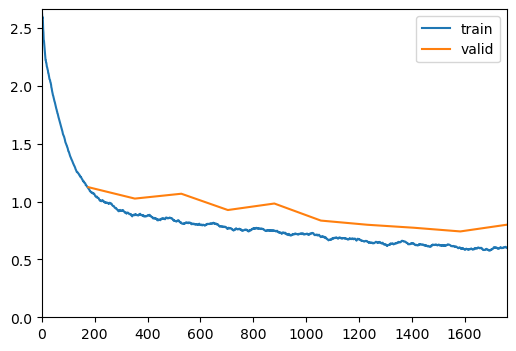

loss: 0.7999922037124634, accuracy:  73.70%


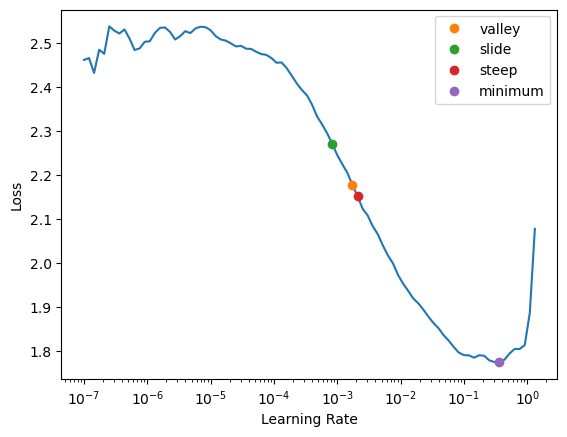

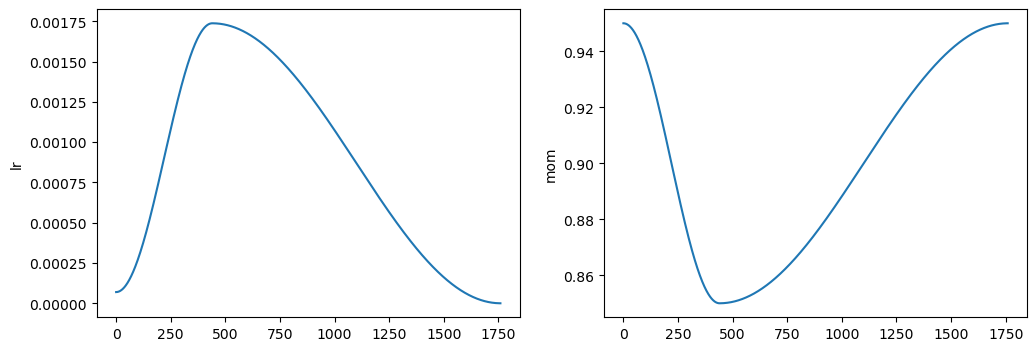

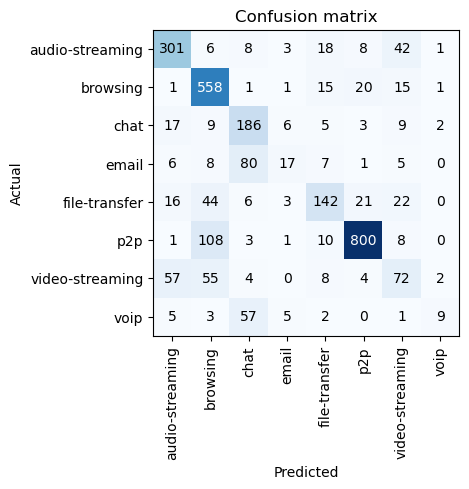

In [15]:
results_res_type_2 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    Simple_Resnet_Model
)

In [16]:
model_1 = results_dnn.model.model.model
model_2 = results_res_type_1.model.model.model
model_3 = results_res_type_2.model.model.model

results_1 = results_dnn.model.model.validate()
results_2 = results_res_type_1.model.model.validate()
results_3 = results_res_type_2.model.model.validate()

print(f"Deep NN 100x10: \t\t\t{sum(p.numel() for p in model_1.parameters() if p.requires_grad)} parameters, {results_1[1]*100} accuracy")
print(f"Deep Res NN 100x10: \t\t\t{sum(p.numel() for p in model_2.parameters() if p.requires_grad)} parameters, {results_2[1]*100} accuracy")
print(f"Simple Res NN 100x10: \t\t{sum(p.numel() for p in model_3.parameters() if p.requires_grad)} parameters, {results_3[1]*100} accuracy")

Deep NN 100x10: 			99342 parameters, 62.03605532646179 accuracy
Deep Res NN 100x10: 			99342 parameters, 69.3884789943695 accuracy
Simple Res NN 100x10: 		96678 parameters, 73.70095252990723 accuracy


In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
assert False, f"Nothing after this point is included in the study. Time: {timestamp}"